In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import h5py
import pickle
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import datetime
from cartopy.feature.nightshade import Nightshade

In [6]:
insatfilepath = r'/data/debasish/insatdata/l1b/2019/2019jan/day01/3RIMG_01JAN2019_0315_L1B_STD_V01R00.h5'
insatfile = h5py.File(insatfilepath, 'r')
insatfile.keys()

<KeysViewHDF5 ['GeoX', 'GeoX1', 'GeoX2', 'GeoY', 'GeoY1', 'GeoY2', 'GreyCount', 'IMG_MIR', 'IMG_MIR_RADIANCE', 'IMG_MIR_TEMP', 'IMG_SWIR', 'IMG_SWIR_RADIANCE', 'IMG_TIR1', 'IMG_TIR1_RADIANCE', 'IMG_TIR1_TEMP', 'IMG_TIR2', 'IMG_TIR2_RADIANCE', 'IMG_TIR2_TEMP', 'IMG_VIS', 'IMG_VIS_ALBEDO', 'IMG_VIS_RADIANCE', 'IMG_WV', 'IMG_WV_RADIANCE', 'IMG_WV_TEMP', 'Latitude', 'Latitude_VIS', 'Latitude_WV', 'Longitude', 'Longitude_VIS', 'Longitude_WV', 'SCAN_LINE_TIME', 'Sat_Azimuth', 'Sat_Elevation', 'Sun_Azimuth', 'Sun_Elevation', 'time']>

In [9]:
def count2bt(count,lut):
    bt = lut[count]
    return bt
tir1count = np.array(insatfile['IMG_TIR1'])[0,:,:]
fillvalue = insatfile['IMG_TIR1'].attrs['_FillValue'][0]
tir1lut = np.array(insatfile['IMG_TIR1_TEMP'])
tir1bt = count2bt(tir1count,tir1lut)
tir1bt[tir1count == fillvalue] = np.nan

tir2count = np.array(insatfile['IMG_TIR2'])[0,:,:]
fillvalue = insatfile['IMG_TIR2'].attrs['_FillValue'][0]
tir2lut = np.array(insatfile['IMG_TIR2_TEMP'])
tir2bt = count2bt(tir2count,tir2lut)
tir2bt[tir2count == fillvalue] = np.nan

mircount = np.array(insatfile['IMG_MIR'])[0,:,:]
fillvalue = insatfile['IMG_MIR'].attrs['_FillValue'][0]
mirlut = np.array(insatfile['IMG_MIR_TEMP'])
mirbt = count2bt(mircount,mirlut)
mirbt[mircount == fillvalue] = np.nan

longitudearray = np.array(insatfile['Longitude'])/100
latitudearray = np.array(insatfile['Latitude'])/100
fillvalue = insatfile['Longitude'].attrs['_FillValue'][0]/100
latitudearray[latitudearray == fillvalue] = np.nan
longitudearray[longitudearray == fillvalue] = np.nan

print(tir1bt.shape, tir2bt.shape, mirbt.shape, latitudearray.shape, longitudearray.shape)

(2816, 2805) (2816, 2805) (2816, 2805) (2816, 2805) (2816, 2805)


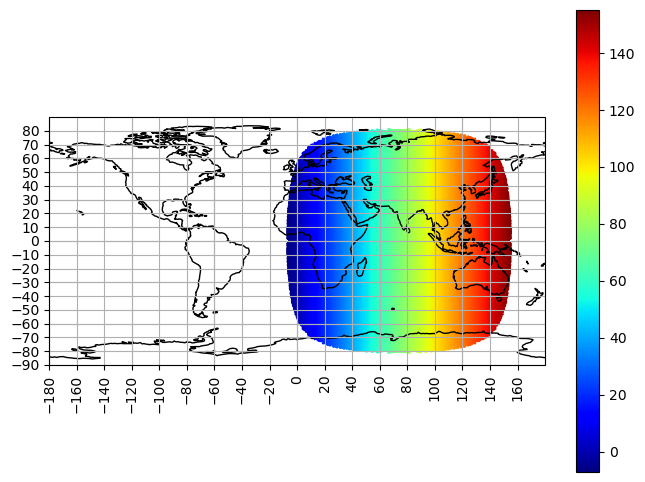

In [14]:
extent=-1
fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection = ccrs.PlateCarree())
plot = plt.scatter(longitudearray.flatten()[0:extent],latitudearray.flatten()[0:extent],
                   c=longitudearray.flatten()[0:extent],
                   s=0.5,cmap='jet',transform=ccrs.PlateCarree())

ax.set_global()
ax.coastlines()
ax.gridlines()
#Make longitude and latitude tick labels
ax.set_xticks(np.arange(-180,180,20),crs=ccrs.PlateCarree())
#Rotate xtixk labels using single line
plt.xticks(rotation = 90)

ax.set_yticks(np.arange(-90,90,10),crs=ccrs.PlateCarree())
plt.grid(True)
plt.colorbar(plot,orientation='vertical')


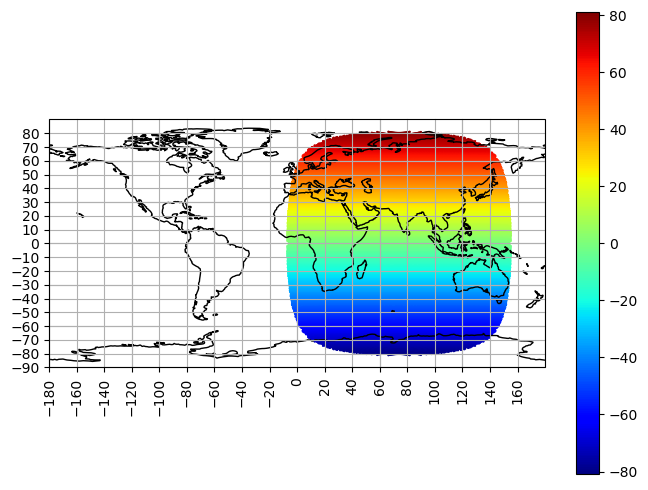

In [15]:
extent=-1
fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection = ccrs.PlateCarree())
plot = plt.scatter(longitudearray.flatten()[0:extent],latitudearray.flatten()[0:extent],
                   c=latitudearray.flatten()[0:extent],
                   s=0.5,cmap='jet',transform=ccrs.PlateCarree())

ax.set_global()
ax.coastlines()
ax.gridlines()
#Make longitude and latitude tick labels
ax.set_xticks(np.arange(-180,180,20),crs=ccrs.PlateCarree())
#Rotate xtixk labels using single line
plt.xticks(rotation = 90)

ax.set_yticks(np.arange(-90,90,10),crs=ccrs.PlateCarree())
plt.grid(True)
plt.colorbar(plot,orientation='vertical')

In [22]:
dfirdata = pd.DataFrame(
    {'btmir': mirbt.flatten(),
     'bttir1': tir1bt.flatten(),
     'bttir2': tir2bt.flatten(),
     'insatcorvislat': latitudearray.flatten(),
     'insatcorvislon': longitudearray.flatten()
     }
)

print(dfirdata.isna().sum())
dfirdata = dfirdata.dropna()
print(dfirdata.isna().sum())

btmir             2126521
bttir1            2125360
bttir2            2125326
insatcorvislat    2137463
insatcorvislon    2137463
dtype: int64
btmir             0
bttir1            0
bttir2            0
insatcorvislat    0
insatcorvislon    0
dtype: int64


In [35]:
scalaradress =r"/data/debasish/cloudetectionmodels/cloudtopheightmodel/untunedxgboost/trainscaler.pkl"
modeladress = r"/data/debasish/cloudetectionmodels/cloudtopheightmodel/untunedxgboost/xgboostcloudtopheightuntunedironly.pkl"

with open(scalaradress, 'rb') as file:
    scaler = pickle.load(file)

with open(modeladress, 'rb') as file:
    model = pickle.load(file)

dfirdatascaled = scaler.transform(dfirdata[['btmir','bttir1','bttir2','insatcorvislat']])
print(dfirdatascaled.shape)

heighprediction = model.predict(dfirdatascaled)
dfirdata['heightprediction'] = heighprediction

(5758344, 4)


In [25]:
type(heighprediction)

numpy.ndarray

count    5.692330e+06
mean     2.231898e+00
std      3.642871e+00
min      3.157498e-05
25%      3.508453e-01
50%      7.971552e-01
75%      1.828186e+00
max      1.776453e+01
Name: heightprediction, dtype: float64

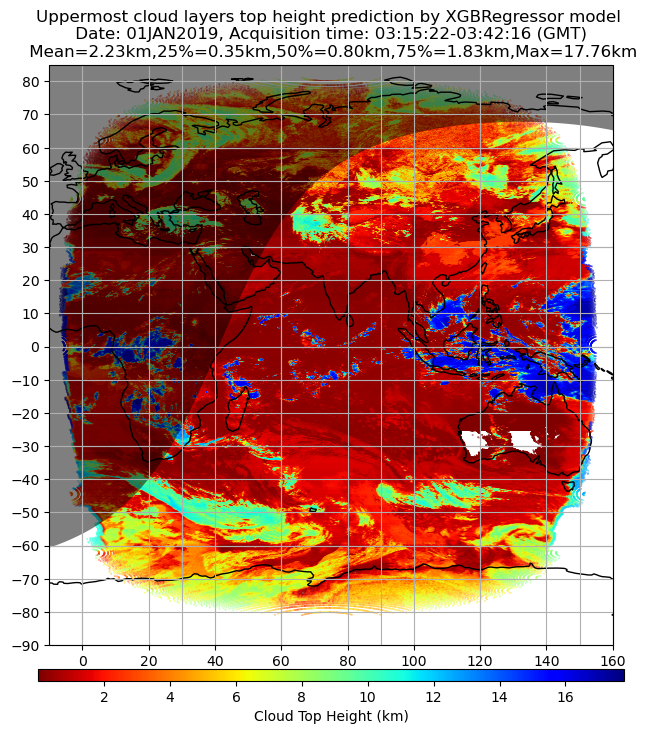

In [75]:
#Get a map and plot the cloud top height

extent=-1

fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection = ccrs.PlateCarree())

dfirdata[dfirdata['heightprediction']<0] = np.nan

plot = plt.scatter(
                dfirdata['insatcorvislon'].values[0:extent],
                dfirdata['insatcorvislat'].values[0:extent],
                c=dfirdata['heightprediction'][0:extent],
                cmap = 'jet_r',
                s=0.05,
                transform=ccrs.PlateCarree()
                )

ax.set_global()
ax.coastlines()
ax.gridlines()

#Make longitude and latitude tick labels
ax.set_xticks(np.arange(-180,180,20),crs=ccrs.PlateCarree())
#Rotate xtixk labels using single line
#plt.xticks(rotation = 90)
ax.set_extent([-10,160,-85,85], crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90,90,10),crs=ccrs.PlateCarree())
plt.grid(True)

insatdate = str(insatfile.attrs['Acquisition_Date'])[2:-1]
#print(insatdate)
insattime = str(insatfile.attrs['Acquisition_Time_in_GMT'])[2:-1]
#print(insattime)
acqstart = str(insatfile.attrs['Acquisition_Start_Time'])[2:-1].split('T')[1]
#print(acqstart)
acqend = str(insatfile.attrs['Acquisition_End_Time'])[2:-1].split('T')[1]
#print(acqend)
year  = int(insatdate[-4:])
month_abbreviation = insatdate[2:5]
month_number = datetime.datetime.strptime(month_abbreviation, '%b').month
day   = int(insatdate[0:2])
hour  = int(insattime[:2])
minute = int(insattime[2:4])

date = datetime.datetime(year,month_number,day,hour,minute,second=0)

date = datetime.datetime(year,month_number,day,hour,minute,second=0)

ax.add_feature(Nightshade(date, alpha=0.5))

cbar = plt.colorbar(plot,orientation='horizontal',pad=0.039, fraction=0.019, aspect=50)
cbar.set_label('Cloud Top Height (km)')
plt.title('Uppermost cloud layers top height prediction by {} model \n Date: {}, Acquisition time: {}-{} (GMT) \n Mean={:.2f}km,25%={:.2f}km,50%={:.2f}km,75%={:.2f}km,Max={:.2f}km'.format(type(model).__name__,insatdate,acqstart,acqend,
                                                                                                                                                                                                                    dfirdata['heightprediction'].mean(),
                                                                                                                                                                                                                    dfirdata['heightprediction'].quantile(0.25),
                                                                                                                                                                                                                    dfirdata['heightprediction'].quantile(0.5),
                                                                                                                                                                                                                    dfirdata['heightprediction'].quantile(0.75),
                                                                                                                                                                                                                    dfirdata['heightprediction'].max()))

#dfirdata['heightprediction'].describe()

#Put this series as a box in the plot



In [63]:
#Get a plot for no. of pixels with cloud top height in range of 0-100m, 100m-1km,1km-5km, 5km -10km 

dfirdata['heightprediction'].describe()

#Put this series as a box in the plot

#Set the precision to 2 decimal places

# dfirdata['heightpredictionrounded'] = dfirdata['heightprediction'].round(2)

# dfirdata['heightpredictionrounded'].describe()

count    5.692330e+06
mean     2.231898e+00
std      3.642871e+00
min      3.157498e-05
25%      3.508453e-01
50%      7.971552e-01
75%      1.828186e+00
max      1.776453e+01
Name: heightprediction, dtype: float64

In [67]:
#Get the 25,50,75 percentile values

dfirdata['heightprediction'].quantile([0.25,0.5,0.75])

0.25    0.350845
0.50    0.797155
0.75    1.828186
Name: heightprediction, dtype: float32

<AxesSubplot:ylabel='Frequency'>

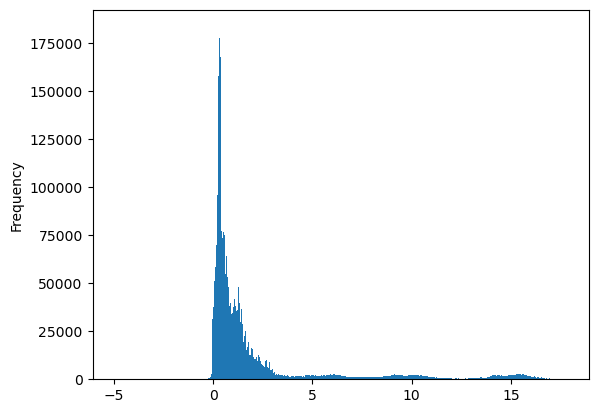

In [53]:
dfirdata['heightprediction'].plot.hist(bins=1000)

In [36]:
dfirdata['heightprediction'].describe()

count    5.758344e+06
mean     2.205369e+00
std      3.630500e+00
min     -4.934605e+00
25%      3.442443e-01
50%      7.817522e-01
75%      1.798590e+00
max      1.776453e+01
Name: heightprediction, dtype: float64

In [42]:
len(dfirdata[dfirdata['heightprediction']<0.1])

225589

(5758344, 4)


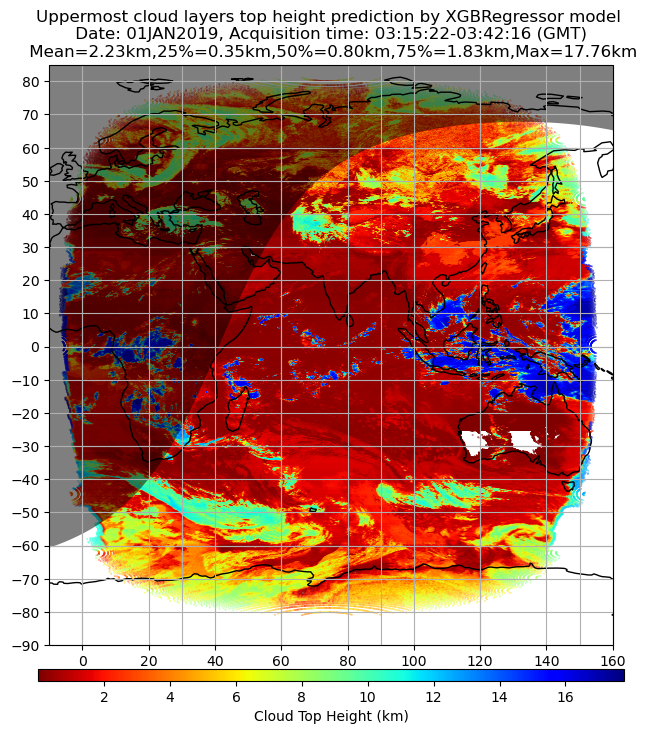

In [80]:
def insatcloudheightprediction(insatfilepath, cmap='jet_r',extent=-1, nightshade='Yes'):
    assert os.path.isfile(insatfilepath)

    insatfile = h5py.File(insatfilepath,'r')

    def count2bt(count,lut):
        bt = lut[count]
        return bt

    tir1count = np.array(insatfile['IMG_TIR1'])[0,:,:]
    fillvalue = insatfile['IMG_TIR1'].attrs['_FillValue'][0]
    tir1lut = np.array(insatfile['IMG_TIR1_TEMP'])
    tir1bt = count2bt(tir1count,tir1lut)
    tir1bt[tir1count == fillvalue] = np.nan

    tir2count = np.array(insatfile['IMG_TIR2'])[0,:,:]
    fillvalue = insatfile['IMG_TIR2'].attrs['_FillValue'][0]
    tir2lut = np.array(insatfile['IMG_TIR2_TEMP'])
    tir2bt = count2bt(tir2count,tir2lut)
    tir2bt[tir2count == fillvalue] = np.nan

    mircount = np.array(insatfile['IMG_MIR'])[0,:,:]
    fillvalue = insatfile['IMG_MIR'].attrs['_FillValue'][0]
    mirlut = np.array(insatfile['IMG_MIR_TEMP'])
    mirbt = count2bt(mircount,mirlut)
    mirbt[mircount == fillvalue] = np.nan

    longitudearray = np.array(insatfile['Longitude'])/100
    latitudearray = np.array(insatfile['Latitude'])/100
    fillvalue = insatfile['Longitude'].attrs['_FillValue'][0]/100
    latitudearray[latitudearray == fillvalue] = np.nan
    longitudearray[longitudearray == fillvalue] = np.nan

    dfirdata = pd.DataFrame(
                {'btmir': mirbt.flatten(),
                'bttir1': tir1bt.flatten(),
                'bttir2': tir2bt.flatten(),
                'insatcorvislat': latitudearray.flatten(),
                'insatcorvislon': longitudearray.flatten()
                }
            )
    dfirdata.dropna(inplace=True)

    scalaradress =r"/data/debasish/cloudetectionmodels/cloudtopheightmodel/untunedxgboost/trainscaler.pkl"
    modeladress = r"/data/debasish/cloudetectionmodels/cloudtopheightmodel/untunedxgboost/xgboostcloudtopheightuntunedironly.pkl"

    with open(scalaradress, 'rb') as file:
        scaler = pickle.load(file)

    with open(modeladress, 'rb') as file:
        model = pickle.load(file)

    dfirdatascaled = scaler.transform(dfirdata[['btmir','bttir1','bttir2','insatcorvislat']])
    print(dfirdatascaled.shape)

    heighprediction = model.predict(dfirdatascaled)
    dfirdata['heightprediction'] = heighprediction
    
    extent = extent

    fig = plt.figure(figsize=(10,8))
    ax = plt.axes(projection=ccrs.PlateCarree())

    dfirdata[dfirdata['heightprediction']<0] = np.nan

    plot = plt.scatter(
                        dfirdata['insatcorvislon'][0:extent],
                        dfirdata['insatcorvislat'][0:extent],
                        c=dfirdata['heightprediction'][0:extent],
                        cmap=cmap,
                        transform=ccrs.PlateCarree(),
                        s=0.05
                        )
    
    ax.set_global()
    ax.coastlines()
    ax.gridlines()

    #Make longitude and latitude tick labels
    ax.set_xticks(np.arange(-180,180,20),crs=ccrs.PlateCarree())
    #Rotate xtixk labels using single line
    #plt.xticks(rotation = 90)
    ax.set_extent([-10,160,-85,85], crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-90,90,10),crs=ccrs.PlateCarree())
    plt.grid(True)


    insatdate = str(insatfile.attrs['Acquisition_Date'])[2:-1]
    insattime = str(insatfile.attrs['Acquisition_Time_in_GMT'])[2:-1]
    acqstart = str(insatfile.attrs['Acquisition_Start_Time'])[2:-1].split('T')[1]
    acqend = str(insatfile.attrs['Acquisition_End_Time'])[2:-1].split('T')[1]   
    year  = int(insatdate[-4:])
    month_abbreviation = insatdate[2:5]
    month_number = datetime.datetime.strptime(month_abbreviation, '%b').month
    day   = int(insatdate[0:2])
    hour  = int(insattime[:2])
    minute = int(insattime[2:4])
    date = datetime.datetime(year,month_number,day,hour,minute,second=0)
    
    if nightshade == 'Yes':
        ax.add_feature(Nightshade(date, alpha=0.5))
    cbar = plt.colorbar(plot,orientation='horizontal',pad=0.039, fraction=0.019, aspect=50)
    cbar.set_label('Cloud Top Height (km)')
    plt.title('Uppermost cloud layers top height prediction by {} model \n Date: {}, Acquisition time: {}-{} (GMT) \n Mean={:.2f}km,25%={:.2f}km,50%={:.2f}km,75%={:.2f}km,Max={:.2f}km'.format(type(model).__name__,insatdate,acqstart,acqend,
                                                                                                                                                                                                                                                                                                                                                                                                                    dfirdata['heightprediction'].mean(),
                                                                                                                                                                                                    dfirdata['heightprediction'].quantile(0.25),
                                                                                                                                                                                                    dfirdata['heightprediction'].quantile(0.5),
                                                                                                                                                                                                    dfirdata['heightprediction'].quantile(0.75),
                                                                                                                                                                                                    dfirdata['heightprediction'].max())
             )
    
    plt.show()

    return dfirdata


#insatcloudheightprediction(insatfilepath=r'/data/debasish/insatdata/l1b/2019/2019jan/day01/3RIMG_01JAN2019_0315_L1B_STD_V01R00.h5');



(5758344, 4)


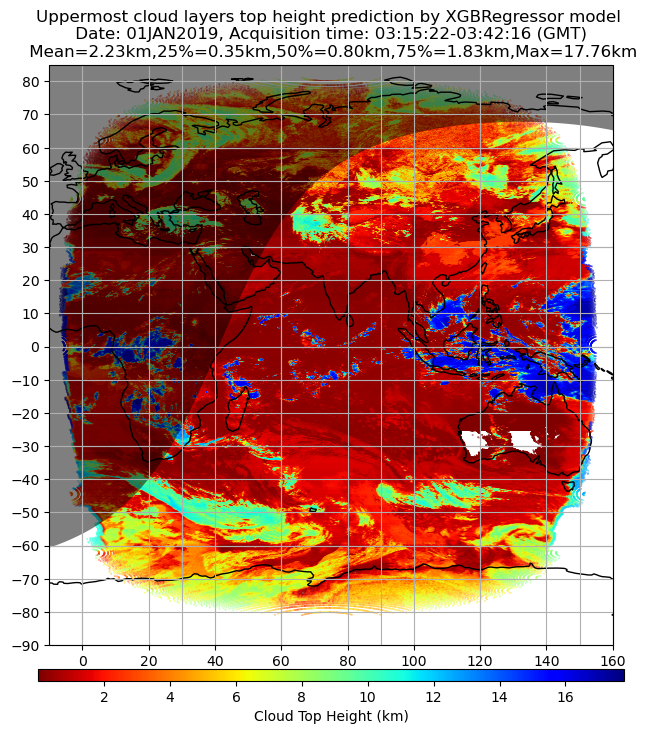

In [81]:
insatcloudheightprediction(insatfilepath=r'/data/debasish/insatdata/l1b/2019/2019jan/day01/3RIMG_01JAN2019_0315_L1B_STD_V01R00.h5');

(5761367, 4)


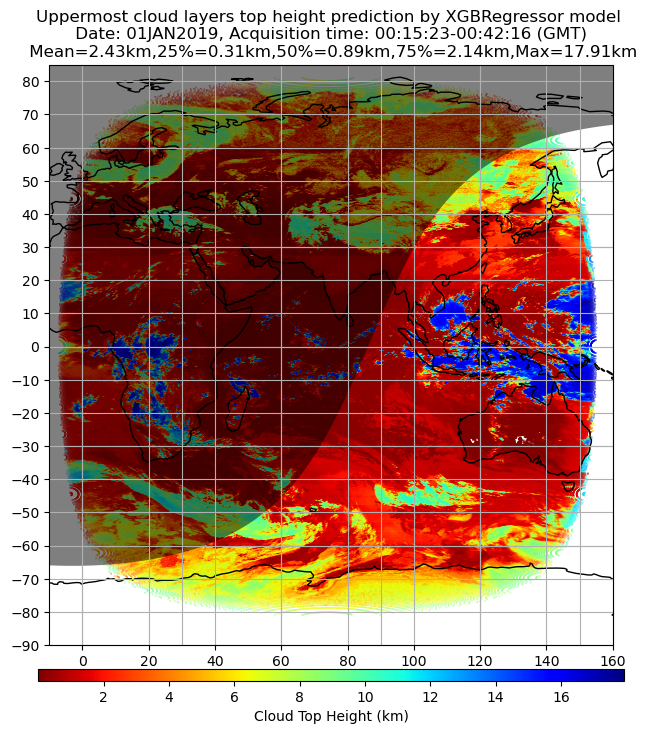

In [82]:
insatcloudheightprediction(insatfilepath=r'/data/debasish/insatdata/l1b/2019/2019jan/day01/3RIMG_01JAN2019_0015_L1B_STD_V01R00.h5');

(5757323, 4)


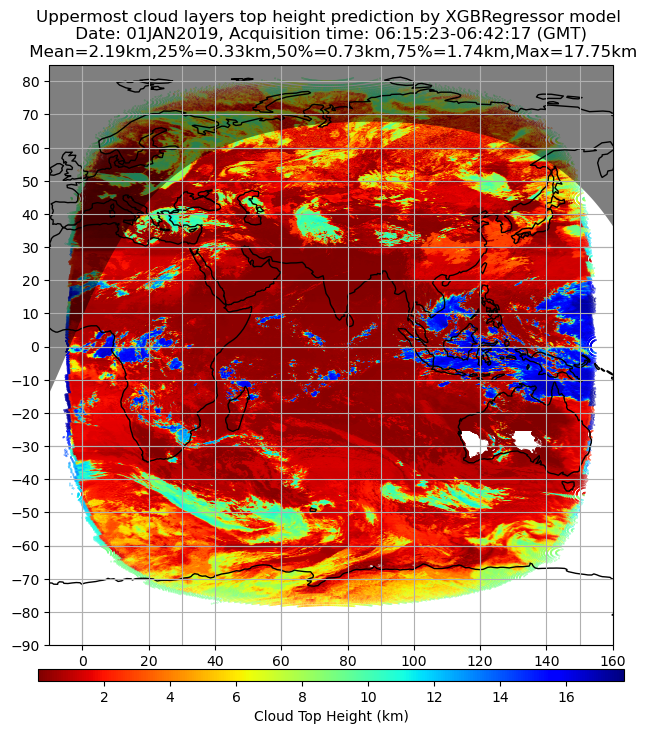

In [83]:
insatcloudheightprediction(insatfilepath=r'/data/debasish/insatdata/l1b/2019/2019jan/day01/3RIMG_01JAN2019_0615_L1B_STD_V01R00.h5');

(5758911, 4)


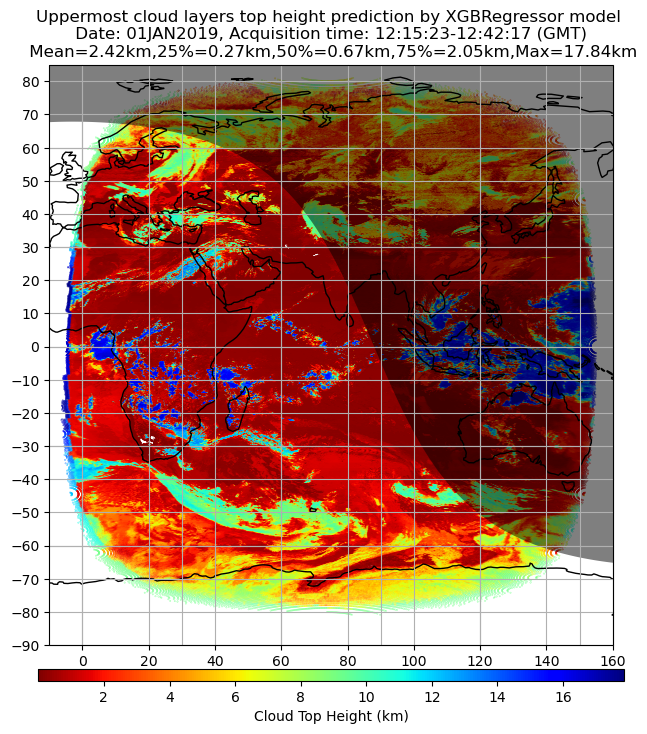

In [84]:
insatcloudheightprediction(insatfilepath=r'/data/debasish/insatdata/l1b/2019/2019jan/day01/3RIMG_01JAN2019_1215_L1B_STD_V01R00.h5');

(5760871, 4)


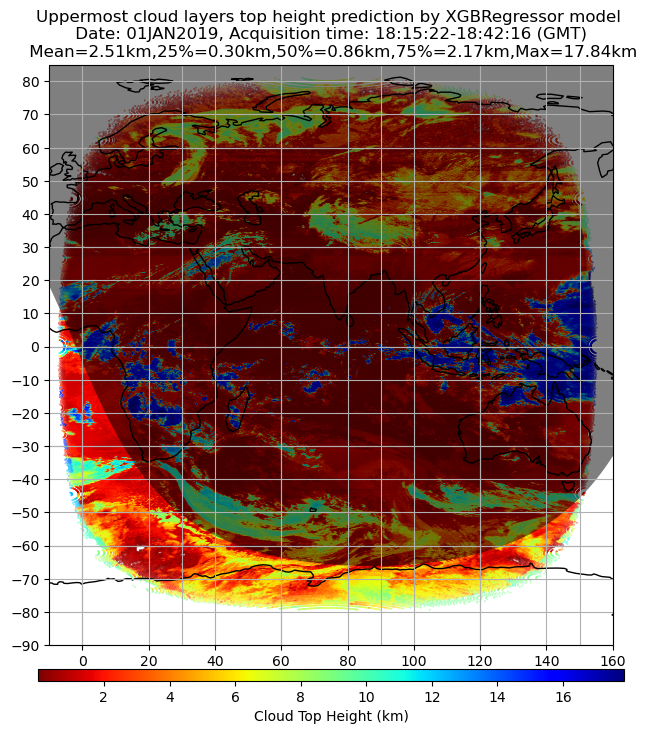

In [85]:
insatcloudheightprediction(insatfilepath=r'/data/debasish/insatdata/l1b/2019/2019jan/day01/3RIMG_01JAN2019_1815_L1B_STD_V01R00.h5');

(5761367, 4)


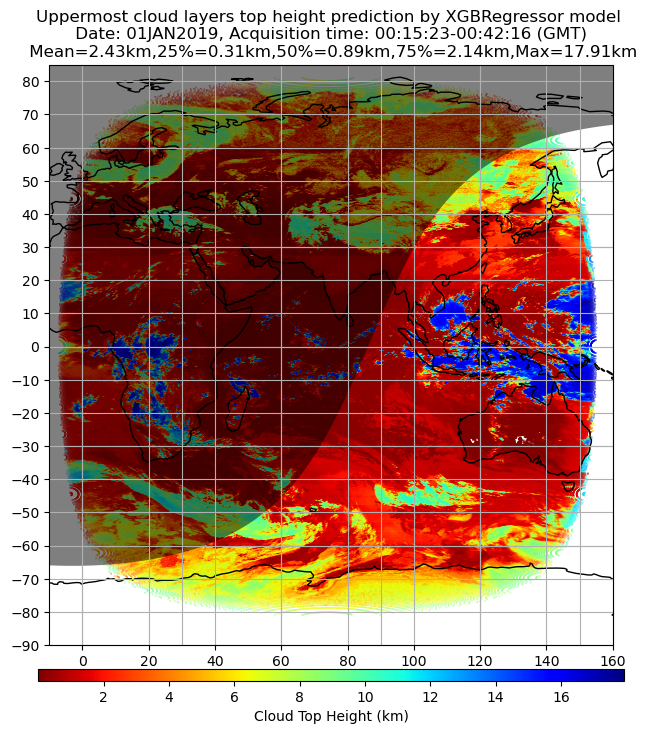

In [86]:
insatcloudheightprediction(insatfilepath=r'/data/debasish/insatdata/l1b/2019/2019jan/day01/3RIMG_01JAN2019_0015_L1B_STD_V01R00.h5');

(5759036, 4)


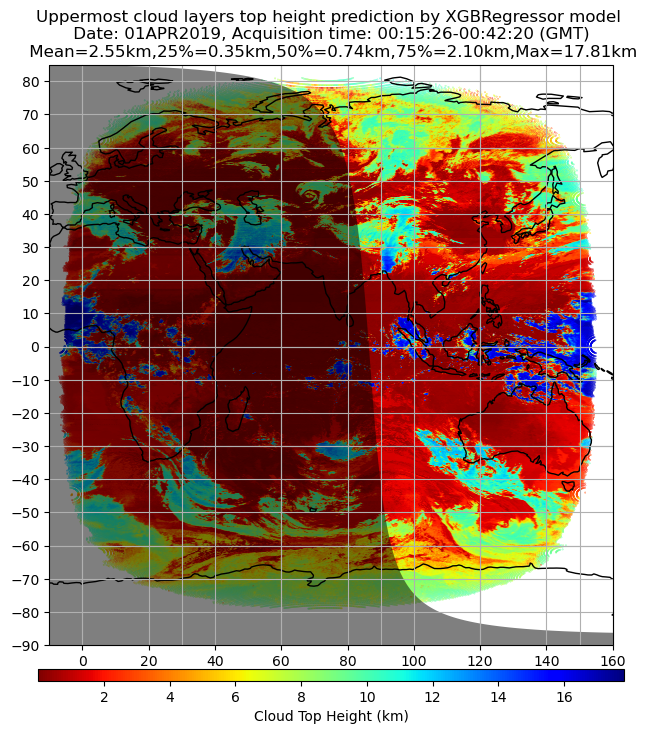

In [90]:
insatcloudheightprediction(r"/data/debasish/insatdata/l1b/2019/apr2019_day1_std/3RIMG_01APR2019_0015_L1B_STD_V01R00.h5");

(5758394, 4)


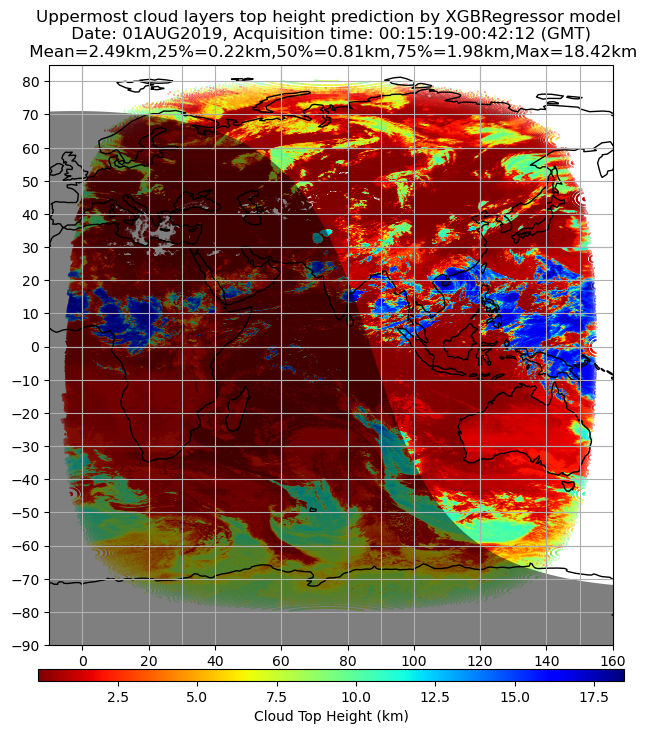

In [89]:
insatcloudheightprediction(r"/data/debasish/insatdata/l1b/2019/aug2019_day1_std/3RIMG_01AUG2019_0015_L1B_STD_V01R00.h5");

(5757833, 4)


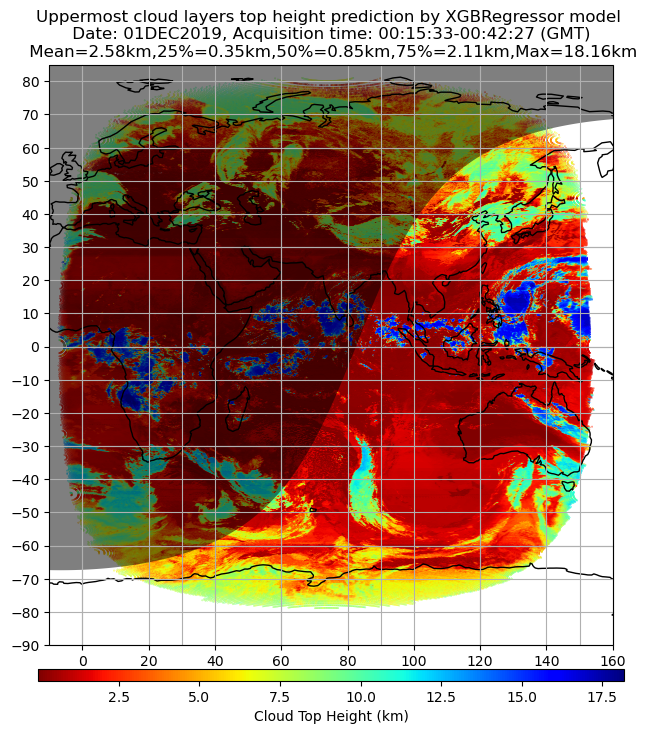

In [91]:
insatcloudheightprediction(r"/data/debasish/insatdata/l1b/2019/dec2019_day1_std/3RIMG_01DEC2019_0015_L1B_STD_V01R00.h5");